In [1]:
%matplotlib inline
import torch
from torch import nn
from matplotlib import pyplot as plt

In [2]:
# 1.数据准备
import numpy as np
from torch.distributions import MultivariateNormal

In [3]:
# 设置两个高斯分布的均值向量和协方差矩阵
mu1 = -3 * torch.ones(2)
mu2 = 3 * torch.ones(2)
mu1, mu1.size()

(tensor([-3., -3.]), torch.Size([2]))

In [4]:
sigma1 = torch.eye(2) * 0.5
sigma2 = torch.eye(2) * 2
sigma1, sigma1.size()

(tensor([[0.5000, 0.0000],
         [0.0000, 0.5000]]),
 torch.Size([2, 2]))

In [5]:
# 从两个多元高斯分布中生成 100 个样本
m1 = MultivariateNormal(mu1, sigma1)
m2 = MultivariateNormal(mu2, sigma2)
m1, m2

(MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2])),
 MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2])))

In [6]:
x1 = m1.sample((100, ))
x2 = m2.sample((100, ))
x1.size(), x2.size()

(torch.Size([100, 2]), torch.Size([100, 2]))

In [7]:
x1[:5], x2[:5]

(tensor([[-2.5078, -3.1862],
         [-4.2433, -3.4708],
         [-2.6084, -2.0602],
         [-3.5995, -2.8951],
         [-2.4140, -3.8791]]),
 tensor([[3.3084, 3.0069],
         [2.0141, 3.1575],
         [2.8256, 3.5519],
         [1.0967, 4.5992],
         [2.0232, 3.7875]]))

In [8]:
y = torch.ones((200, 1))
y.size()

torch.Size([200, 1])

In [9]:
# 设置正负样本的标签
y[100:] = 1

In [10]:
x = torch.cat((x1, x2), 0)
x.size()

torch.Size([200, 2])

In [11]:
# 组合，打乱样本
idx1 = np.random.permutation(10)
idx1, len(x)

(array([2, 5, 9, 6, 7, 3, 0, 1, 8, 4]), 200)

In [12]:
idx = np.random.permutation(len(x))

In [13]:
a = torch.arange(6).reshape(3, 2)
a

tensor([[0, 1],
        [2, 3],
        [4, 5]])

In [14]:
b = np.random.permutation(len(a))
b

array([1, 2, 0])

In [15]:
a1 = a[b]
a1

tensor([[2, 3],
        [4, 5],
        [0, 1]])

In [16]:
x = x[idx]
y = y[idx]

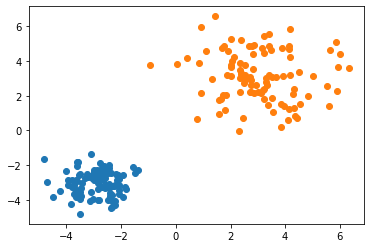

In [17]:
# 绘制样本
plt.scatter(x1.numpy()[:, 0], x1.numpy()[:, 1])
plt.scatter(x2.numpy()[:, 0], x2.numpy()[:, 1])

In [18]:
# 2.线性方程
D_in, D_out = 2, 1
linear = nn.Linear(D_in, D_out, bias = True)
output = linear(x)
output[:5], output.size()

(tensor([[ 1.8503],
         [-1.6206],
         [-1.9310],
         [-2.1195],
         [-2.5225]], grad_fn=<SliceBackward>),
 torch.Size([200, 1]))

In [19]:
x.shape, linear.weight.shape, linear.bias.shape

(torch.Size([200, 2]), torch.Size([1, 2]), torch.Size([1]))

In [20]:
def my_linear(x, w, b):
    return torch.mm(x, w.t()) + b

In [21]:
torch.sum(output - my_linear(x, linear.weight, linear.bias))

tensor(0., grad_fn=<SumBackward0>)

In [22]:
linear.weight, linear.bias, linear.parameters

(Parameter containing:
 tensor([[-0.2102, -0.3813]], requires_grad=True),
 Parameter containing:
 tensor([-0.2776], requires_grad=True),
 <bound method Module.parameters of Linear(in_features=2, out_features=1, bias=True)>)

In [23]:
# 3.激活函数
sigmoid = nn.Sigmoid()
score = sigmoid(output)
score[:5], score.size()

(tensor([[0.8642],
         [0.1651],
         [0.1266],
         [0.1072],
         [0.0743]], grad_fn=<SliceBackward>),
 torch.Size([200, 1]))

In [24]:
def my_sigmoid(x):
    x = 1 / (1 + torch.exp(-x))
    return x

In [25]:
(my_sigmoid(output) - score)[:5]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SliceBackward>)

In [26]:
torch.sum(my_sigmoid(output) - score)

tensor(2.2352e-08, grad_fn=<SumBackward0>)

In [27]:
# 4.损失函数
loss = nn.BCELoss()
loss(score, y)

tensor(1.2241, grad_fn=<BinaryCrossEntropyBackward>)

In [28]:
def my_loss(x, y):
    loss = - torch.mean(torch.log(x) * y + torch.log(1 - x) * (1 - y))
    return loss

In [29]:
my_loss(score, y)

tensor(1.2241, grad_fn=<NegBackward>)

In [30]:
import torch.nn as nn

In [31]:
class LogisticRegression(nn.Module):
    def __init__(self, D_in, D_out):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(D_in, D_out)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.linear(x)
        output = self.sigmoid(x)
        return output

In [32]:
lr_model = LogisticRegression(2, 1)

In [33]:
loss = nn.BCELoss()
loss(lr_model(x), y)

tensor(1.1905, grad_fn=<BinaryCrossEntropyBackward>)

In [34]:
# 5.优化算法
optimizer = torch.optim.SGD(lr_model.parameters(), lr = 0.03)

In [35]:
batch_size = 10
iters = 10

In [36]:
for _  in range(iters):
    for i in range(int(len(x) / batch_size)):
        input1 = x[i * batch_size: (i + 1) * batch_size]
        target = y[i * batch_size: (i + 1) * batch_size]
        optimizer.zero_grad()
        output = lr_model(input1)
        l = loss(output, target)
        l.backward()
        optimizer.step()

In [37]:
pred_neg = (output <= 0.5).view(-1)
pred_pos = (output > 0.5).view(-1)

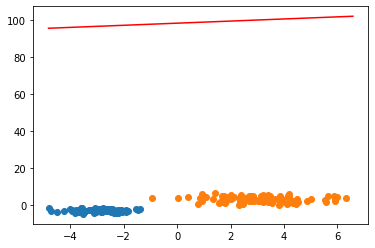

In [51]:
# 失败了
plt.scatter(x1.numpy()[:, 0], x1.numpy()[:, 1])
plt.scatter(x2.numpy()[:, 0], x2.numpy()[:, 1])
w = lr_model.linear.weight[0]
b = lr_model.linear.bias[0]
def draw_decision_boundary(w, b, x0):
    x1 = (-b - w[0] * x0) / w[1]
    plt.plot(x0.detach().numpy(), x1.detach().numpy(), 'r')
draw_decision_boundary(w, b, torch.linspace(x.min(), x.max(), 50))

In [40]:
w.size(), b.size()

(torch.Size([2]), torch.Size([]))

In [41]:
torch.linspace(x.min(), x.max(), 50)

tensor([-4.8129, -4.5805, -4.3480, -4.1155, -3.8830, -3.6505, -3.4181, -3.1856,
        -2.9531, -2.7206, -2.4882, -2.2557, -2.0232, -1.7907, -1.5582, -1.3258,
        -1.0933, -0.8608, -0.6283, -0.3959, -0.1634,  0.0691,  0.3016,  0.5341,
         0.7665,  0.9990,  1.2315,  1.4640,  1.6964,  1.9289,  2.1614,  2.3939,
         2.6264,  2.8588,  3.0913,  3.3238,  3.5563,  3.7887,  4.0212,  4.2537,
         4.4862,  4.7187,  4.9511,  5.1836,  5.4161,  5.6486,  5.8810,  6.1135,
         6.3460,  6.5785])

In [49]:
w, b

(tensor([ 0.0102, -0.0178], grad_fn=<SelectBackward>),
 tensor(1.7561, grad_fn=<SelectBackward>))